# Env

## Hardware

- Two EC2 [c5.2xlarge](https://aws.amazon.com/ec2/instance-types/c5/) instances are used to run the benchmark, each instance has 8 vCPU, 16GB memory and 10G network.

- `ping` stats

```
rtt min/avg/max/mdev = 0.076/0.083/0.093/0.012 ms
```

- `iperf` stats

```bash
$ iperf -c host-0 -p 10000 --parallel 1 -t 10
[ ID] Interval       Transfer     Bandwidth
[  3]  0.0-10.0 sec  5.79 GBytes  4.98 Gbits/sec

$ iperf -c host-0 -p 10000 --parallel 2 -t 10
[ ID] Interval       Transfer     Bandwidth
[  3]  0.0-10.0 sec  5.79 GBytes  4.98 Gbits/sec
[  4]  0.0-10.0 sec  5.79 GBytes  4.98 Gbits/sec
[SUM]  0.0-10.0 sec  11.6 GBytes  9.95 Gbits/sec
```

## Software

- AdoptOpenJDK 13 is used to run the servers.

```bash
$ java -version
openjdk version "13.0.2" 2020-01-14
OpenJDK Runtime Environment AdoptOpenJDK (build 13.0.2+8)
OpenJDK 64-Bit Server VM AdoptOpenJDK (build 13.0.2+8, mixed mode, sharing)
```

- `h2load` is the benchmark client

```bash
$ h2load --version
h2load nghttp2/1.30.0
```

# Benchmark code

To ease the analysis, the benchmark codes of [Netty](https://github.com/TechEmpower/FrameworkBenchmarks/tree/master/frameworks/Java/netty) and [armeria](https://github.com/TechEmpower/FrameworkBenchmarks/tree/master/frameworks/Java/armeria) are ported from the original TechEmpower repo into a sub-project [examples/techempower-base](https://github.com/openaphid/armeria/tree/benchmark-techempower/examples/techempower-base) of armeria.

There are several special optimizations in the Netty server, some of them are not fair or are not present in the armeria server. More commits are added to make the two servers share the same configurations as my focus is to understand the overhead of armeria.

## v0.0.0

- [6df859b95](https://github.com/openaphid/armeria/commit/6df859b958291cff17f795bc2b3ab4b9bd9bc331)
  - The initial port

```bash
export FULL_JAR=examples/techempower-base/build/libs/armeria-examples-techempower-base-0.99.3-SNAPSHOT-all.jar
git checkout 6df859b95
./gradlew -PnoCheckstyle -PnoWeb -p examples/techempower-base/ clean build; cp $FULL_JAR techempower-base-0.0.0.jar

```

## v0.1.0

Changes to Netty server:

- [b7ee0b19f](https://github.com/openaphid/armeria/commit/b7ee0b19f555c94b7ea848ef0b506bbdfbdc6e6d)
  - Stop caching the value of `content-length` as it's not common in practical.
  - Make the length of `content-type` and `server` be the same as in the armeria server.
  - Use `HttpTimestampSupplier` to generate `date` header
  
- [39427ce39](https://github.com/openaphid/armeria/commit/39427ce396a10cfc57156198d1d6306a89652848)
  - Switch to `jackson` from `jsoniter` as the later may be a bit faster, which is not used in armeria
  
- [dfabd9a00](https://github.com/openaphid/armeria/commit/dfabd9a0091dbe480d395559ed5c30e7eaa19d92)
  - Add `FlushConsolidationHandler`

Changes to armeria server:

- [df596c463](https://github.com/openaphid/armeria/commit/df596c4634299a3d2e2453905d31c0ee159d3ad5)
  - Disable `ResourceLeakDetector` for armeria server too
  - Use the same channel options for armeria server
  
- [9e452473a](https://github.com/openaphid/armeria/commit/9e452473ae459e8847eadf3953903e1c3e788754)
  - Disable request timeout as it's not present in Netty server
  - Use `NoopMeterRegistry`
  
- Some system properties could be set to run armeria server:
  - `-Dcom.linecorp.armeria.verboseExceptions=false` disables an internal exception sampler.
  - `-Dcom.linecorp.armeria.validateHeaders=false` disables header validation

```
git checkout 9e452473a
./gradlew -PnoCheckstyle -PnoWeb -p examples/techempower-base/ clean build
cp $FULL_JAR techempower-base-0.1.0.jar
```

# Running Benchmarks

## v0.0.0

- Benchmark the Netty server

```bash
# on host-0
java -jar techempower-base-0.0.0.jar netty 8080

# on host-1
python3 -u run_h2load.py host-0 json | tee netty-0.0.0.log
```

- Benchmark the armeria server

```bash
# on host-0
java -jar techempower-base-0.0.0.jar armeria 8080

# on host-1
python3 -u run_h2load.py host-0 json | tee armeria-0.0.0.log

```

## v0.1.0

- Benchmark the Netty server

```bash
# on host-0
java -jar techempower-base-0.1.0.jar netty 8080

# on host-1
python3 -u run_h2load.py host-0 json | tee netty-0.1.0.log
```

- Benchmark the armeria server

```bash
# on host-0
java -Dcom.linecorp.armeria.verboseExceptions=false -Dcom.linecorp.armeria.validateHeaders=false -jar techempower-base-0.1.0.jar armeria 8080

# on host-1
python3 -u run_h2load.py host-0 json | tee armeria-0.1.0.log

```


# Plots

In [1]:
from h2load_log_parser import parse_h2load_log, plot_results
from IPython.display import display
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

base_dir = "remote-logs/round-2"
netty_000 = parse_h2load_log(f'{base_dir}/netty-0.0.0.log')
armeria_000 = parse_h2load_log(f'{base_dir}/armeria-0.0.0.log')
netty_010 = parse_h2load_log(f'{base_dir}/netty-0.1.0.log')
armeria_010 = parse_h2load_log(f'{base_dir}/armeria-0.1.0.log')

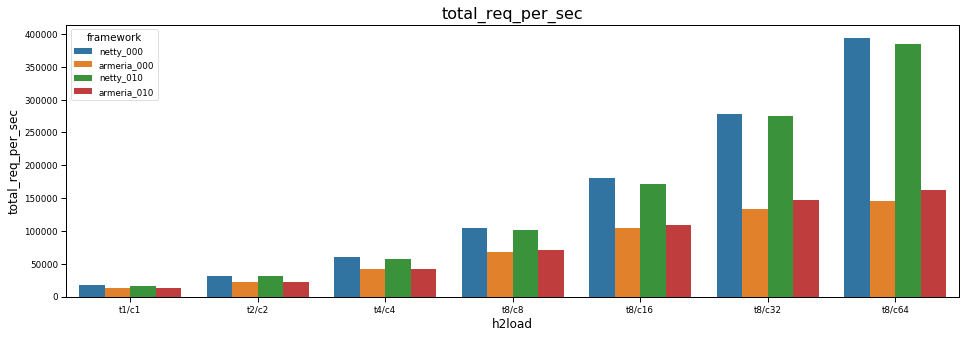

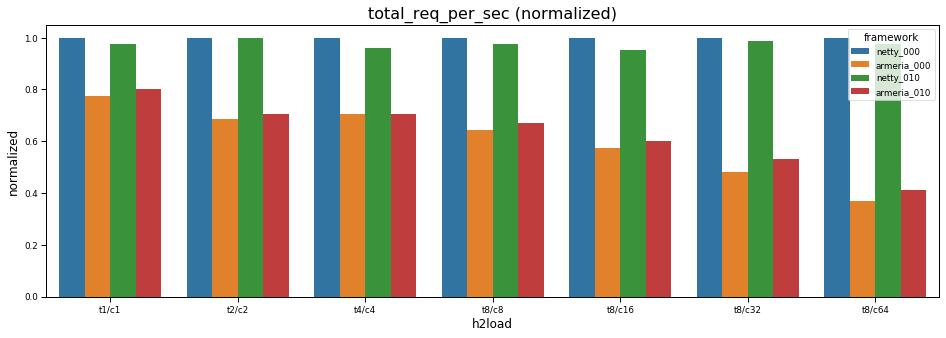

,h2load,framework,total_req_per_sec,normalized
0,t1/c1,netty_000,16979.40,1.000000
1,t1/c1,armeria_000,13167.73,0.775512
2,t1/c1,netty_010,16580.80,0.976524
3,t1/c1,armeria_010,13584.63,0.800065
4,t2/c2,netty_000,31714.97,1.000000
5,t2/c2,armeria_000,21756.40,0.685998
6,t2/c2,netty_010,31685.17,0.999060
7,t2/c2,armeria_010,22391.30,0.706017
8,t4/c4,netty_000,60242.57,1.000000
9,t4/c4,armeria_000,42443.53,0.704544


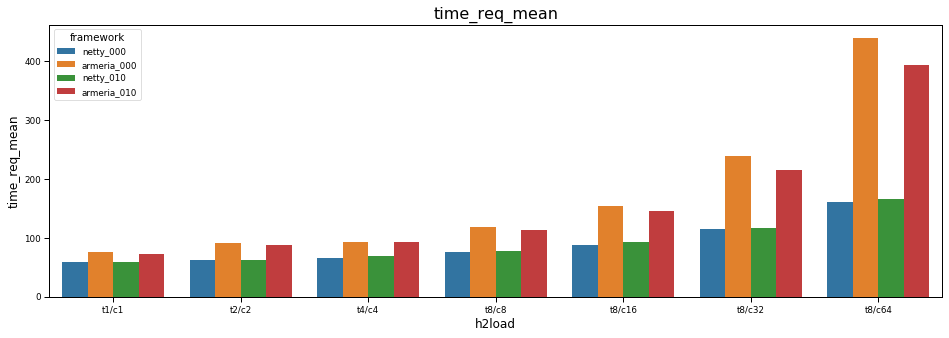

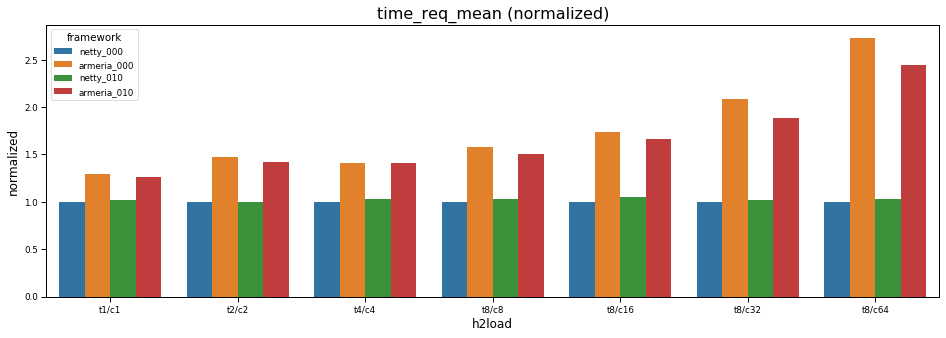

,h2load,framework,time_req_mean,normalized
0,t1/c1,netty_000,58.0,1.000000
1,t1/c1,armeria_000,75.0,1.293103
2,t1/c1,netty_010,59.0,1.017241
3,t1/c1,armeria_010,73.0,1.258621
4,t2/c2,netty_000,62.0,1.000000
5,t2/c2,armeria_000,91.0,1.467742
6,t2/c2,netty_010,62.0,1.000000
7,t2/c2,armeria_010,88.0,1.419355
8,t4/c4,netty_000,66.0,1.000000
9,t4/c4,armeria_000,93.0,1.409091


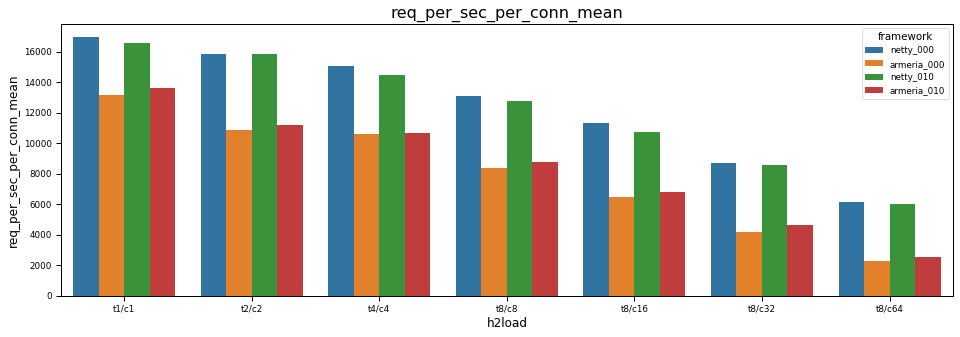

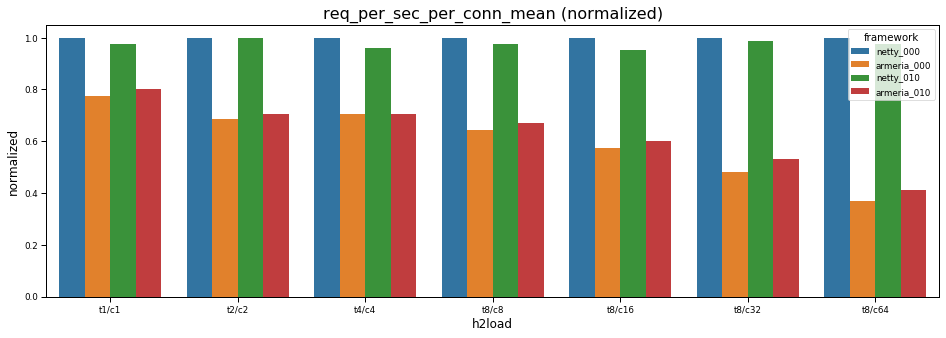

,h2load,framework,req_per_sec_per_conn_mean,normalized
0,t1/c1,netty_000,16979.35,1.000000
1,t1/c1,armeria_000,13167.72,0.775514
2,t1/c1,netty_010,16580.78,0.976526
3,t1/c1,armeria_010,13584.61,0.800067
4,t2/c2,netty_000,15857.47,1.000000
5,t2/c2,armeria_000,10878.18,0.685997
6,t2/c2,netty_010,15842.57,0.999060
7,t2/c2,armeria_010,11195.62,0.706016
8,t4/c4,netty_000,15060.62,1.000000
9,t4/c4,armeria_000,10610.86,0.704543


In [12]:
results_tuples = [('netty_000', netty_000), ('armeria_000', armeria_000),
                  ('netty_010', netty_010), ('armeria_010', armeria_010)]

for i in ['total_req_per_sec', 'time_req_mean', 'req_per_sec_per_conn_mean']:
    plot_results(results_tuples, i, normalize=False) # plot the raw numbers
    df = plot_results(results_tuples, i, normalize=True) # plot the normalized numbers
    display(df) # show the raw data

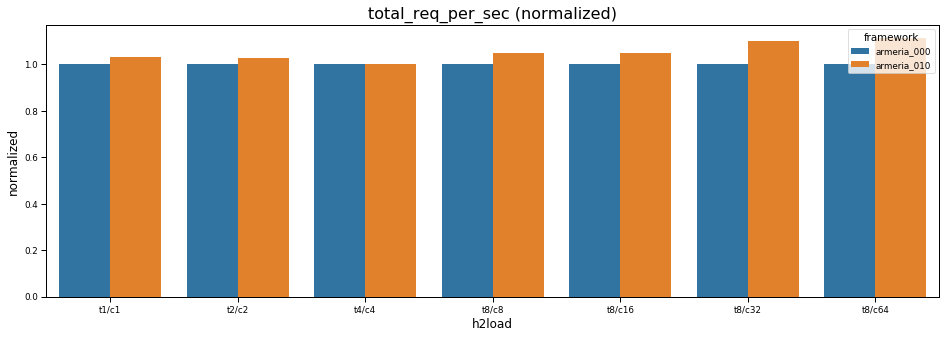

,h2load,framework,total_req_per_sec,normalized
0,t1/c1,armeria_000,13167.73,1.000000
1,t1/c1,armeria_010,13584.63,1.031661
2,t2/c2,armeria_000,21756.40,1.000000
3,t2/c2,armeria_010,22391.30,1.029182
4,t4/c4,armeria_000,42443.53,1.000000
5,t4/c4,armeria_010,42545.63,1.002406
6,t8/c8,armeria_000,67150.07,1.000000
7,t8/c8,armeria_010,70299.70,1.046904
8,t8/c16,armeria_000,103788.20,1.000000
9,t8/c16,armeria_010,108744.10,1.047750


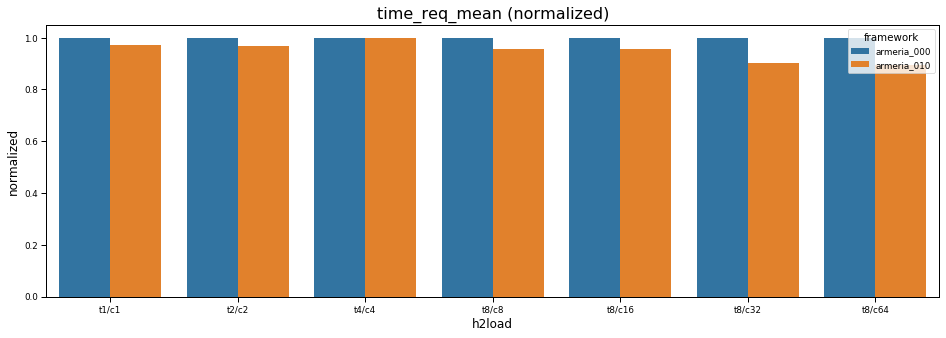

,h2load,framework,time_req_mean,normalized
0,t1/c1,armeria_000,75.0,1.000000
1,t1/c1,armeria_010,73.0,0.973333
2,t2/c2,armeria_000,91.0,1.000000
3,t2/c2,armeria_010,88.0,0.967033
4,t4/c4,armeria_000,93.0,1.000000
5,t4/c4,armeria_010,93.0,1.000000
6,t8/c8,armeria_000,118.0,1.000000
7,t8/c8,armeria_010,113.0,0.957627
8,t8/c16,armeria_000,153.0,1.000000
9,t8/c16,armeria_010,146.0,0.954248


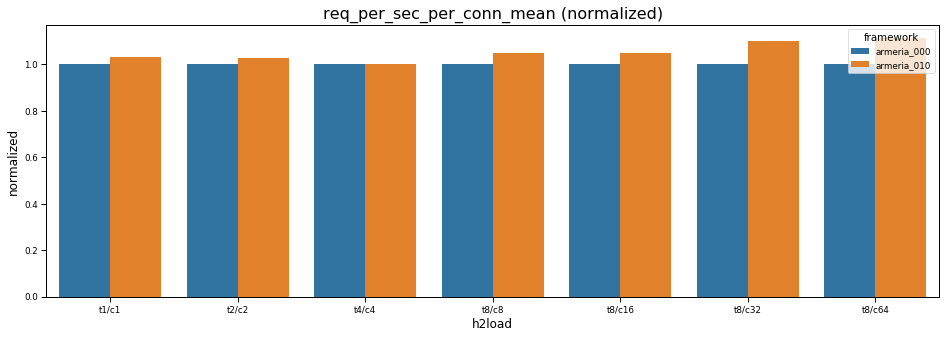

,h2load,framework,req_per_sec_per_conn_mean,normalized
0,t1/c1,armeria_000,13167.72,1.000000
1,t1/c1,armeria_010,13584.61,1.031660
2,t2/c2,armeria_000,10878.18,1.000000
3,t2/c2,armeria_010,11195.62,1.029181
4,t4/c4,armeria_000,10610.86,1.000000
5,t4/c4,armeria_010,10636.39,1.002406
6,t8/c8,armeria_000,8393.74,1.000000
7,t8/c8,armeria_010,8787.41,1.046900
8,t8/c16,armeria_000,6486.73,1.000000
9,t8/c16,armeria_010,6796.49,1.047753


In [3]:
armeria_tuples = [('armeria_000', armeria_000), ('armeria_010', armeria_010)]
for i in ['total_req_per_sec', 'time_req_mean', 'req_per_sec_per_conn_mean']:
    df = plot_results(armeria_tuples, i, normalize=True)
    display(df)

# Profiling

## async-profiler

```bash
# Capture cpu and alloc events data while running a `c=64` load test.
./profiler.sh -e alloc -i 100us -f armeria-alloc-0.1.0.svg -d 30 --width 2000 --title "Armeria alloc v0.1.0" `pidof java`
./profiler.sh -e cpu -i 100us -f armeria-cpu-0.1.0.svg -d 30 --width 2000 --title "Armeria cpu v0.1.0" `pidof java`
```

In [4]:
from IPython.display import FileLink

display(FileLink('remote-logs/armeria-alloc-0.1.0.svg'))
display(FileLink('remote-logs/armeria-cpu-0.1.0.svg'))

/Volumes/Data/Openaphid/armeria/examples/techempower-base/notebook/remote-logs/armeria-alloc-0.1.0.svg

/Volumes/Data/Openaphid/armeria/examples/techempower-base/notebook/remote-logs/armeria-cpu-0.1.0.svg

## Object allocations 

`yourkit` is used to log the accurate number of object allocations for 10000 requests:

In [10]:
def load_allocation_df(path, min_allocation=500):
    df = pd.read_csv(path).filter(['Allocation', 'Objects Created'])
    return df[df['Objects Created'] > min_allocation]

# Netty allocations
load_allocation_df('remote-logs/netty-allocated-objects-10k.csv')

,Allocation,Objects Created
0,io.netty.handler.codec.DefaultHeaders$HeaderEntry,90000
1,char[],80663
2,java.lang.String,80295
3,io.netty.handler.codec.DefaultHeaders$HeaderEntry[],30000
4,io.netty.handler.codec.DefaultHeadersImpl,30000
5,io.netty.handler.codec.http.DefaultHttpHeaders,30000
6,com.fasterxml.jackson.core.json.JsonWriteContext,20000
7,java.util.LinkedList,20000
8,byte[],10352
9,java.lang.String[],10009


In [11]:
# Armeria allocations
load_allocation_df('remote-logs/armeria-allocated-objects-10k.csv')

,Allocation,Objects Created
0,com.linecorp.armeria.common.StringMultimap$Entry,160000
1,char[],151374
2,java.lang.String,120678
3,io.netty.handler.codec.DefaultHeaders$HeaderEntry,100000
4,java.util.concurrent.CompletableFuture,90000
5,java.util.ArrayList$Itr,70045
6,com.linecorp.armeria.common.HttpHeadersBase,50000
7,java.lang.Object[],40390
8,io.netty.channel.DefaultChannelPromise,30001
9,com.linecorp.armeria.common.stream.AbstractStreamMessage$SubscriptionImpl,30000
